# Imports

In [1]:
import keras
import datasets
import numpy as np
import transformers
import datetime
import os
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import tensorflow as tf
import tqdm.notebook as tqdm
import tensorflow_datasets as tfds
import sklearn.model_selection
import matplotlib.pyplot as plt
from typing import List
import pandas as pd
from pathlib import Path  

2024-11-30 08:30:26.184733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 08:30:26.197593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 08:30:26.201624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 08:30:26.211234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

I0000 00:00:1732919435.950791   26796 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732919436.057965   26796 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732919436.058060   26796 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


# Global params

In [61]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
OUTPUT = 28
EPOCHS = 10

In [62]:
np.random.seed(42)

# Dataset

Load the dataset (we will be using [go_emotions](https://huggingface.co/datasets/google-research-datasets/go_emotions)). Pretokenize data or make a loader that tokenizes the sentenses as you iterate through the dataset. Implement two datasets: variable and fixed sentence length (in tokens). Don't forget to split the dataset into train and test subsets

In [32]:
dataset = datasets.load_dataset('google-research-datasets/go_emotions', name='raw', split='train')

In [33]:
dataset.column_names

['text',
 'id',
 'author',
 'subreddit',
 'link_id',
 'parent_id',
 'created_utc',
 'rater_id',
 'example_very_unclear',
 'admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [34]:
emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
    'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
    'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

In [35]:
tokenizer = transformers.AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

In [36]:
def get_target(item):
    item['lables'] = [item[key] for key in emotions]

    return item

In [37]:
def get_dataset(dataset: datasets.arrow_dataset.Dataset, is_train: bool = False):
    process_data = dataset.map(lambda item: tokenizer(item['text'], padding='max_length', max_length=64, truncation=True))
    process_data = process_data.map(get_target)
    
    tf_ds = process_data.to_tf_dataset(
        columns=["input_ids"],
        label_cols=["lables"],
        batch_size=BATCH_SIZE,
        shuffle=is_train,
    )
    
    return tf_ds

In [38]:
# Train / validation / test split
splited_dataset = dataset.train_test_split(test_size=0.1)
test_data_set = splited_dataset['test']
splited_dataset = splited_dataset['train'].train_test_split(test_size=0.1)
train_dataset = splited_dataset['train']
validation_dataset = splited_dataset['test']

In [39]:
# Prepare data
test = get_dataset(test_data_set)
train = get_dataset(train_dataset, True)
validation = get_dataset(validation_dataset)

/home/timohavdk/miniconda3/envs/tf-3/lib/python3.10/site-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [14]:
def getOneItemFromDataset(dataset):
    ind = 0
    elem_ind = 1

    for item in dataset.as_numpy_iterator():
        if ind < 1:
            print(item[0][elem_ind])
            print(tokenizer.decode(item[0][elem_ind]).replace('<|endoftext|>', ''))
            print(item[1][elem_ind])
        else: 
            break
        ind += 1

In [82]:
getOneItemFromDataset(validation)

[   29 10161 36083   588   428   481   651   345  2923    13  1320   318
  1165  2089    11  6402   314   373  5410   319  2877  8097    13 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256]
>Emotions like this will get you killed. That is too bad, considering I was planning on living forever.
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Model

Implement your model. The model should have the RNN architecture (with LSTM or GRU cells), support stacking and bidirectional feature extraction.

In [63]:
def get_name(prefix: str | None = None, suffix: str | None = None, separator: str = '_') -> str | None:
    return prefix and prefix + separator + suffix or suffix or None

In [64]:
def get_model(
    units: int,
    n_tokens: int,
    n_labels: int,
    n_stacks: int = 1,
    bidirectional: bool = False,
    name: str | None = None,
    cell_type: type[keras.layers.Layer] = keras.layers.LSTMCell
) -> keras.Model:
    def apply_rnn(x):
        rnn_layer_template = keras.layers.LSTM(units, return_sequences=False, name=get_name(name, 'lstm'))
        
        rnn_layer = rnn_layer_template

        if bidirectional:
            rnn_layer = keras.layers.Bidirectional(rnn_layer_template)

            if n_stacks > 1:
                new_x = keras.layers.Bidirectional(keras.layers.LSTM(units, return_sequences=True, name=get_name(name, 'lstm')))(x)
                return keras.layers.Bidirectional(rnn_layer_template)(new_x)
            else:
                return rnn_layer(x)
            
        elif n_stacks > 1:
            rnn_cells = [cell_type(units) for _ in range(n_stacks)]
            stacked_lstm = keras.layers.StackedRNNCells(rnn_cells)
            rnn_layer = keras.layers.RNN(stacked_lstm)

            return rnn_layer(x)
        else:
            return rnn_layer(x)

    

    inputs = keras.layers.Input((64, ), name=get_name(name, 'inputs_tokens'))
    x = keras.layers.Embedding(input_dim=n_tokens, output_dim=64, name=get_name(name, 'embedding'))(inputs)
    x = apply_rnn(x)
    outputs = keras.layers.Dense(n_labels, activation="sigmoid", name=get_name(name, 'prediction'))(x)

    return keras.Model(inputs=inputs, outputs=outputs, name=name)


# Training

Train several models on the two dataset variants. Use either of the cell types (LSTM or GRU)
* Simple RNN (no stacking, one direction)
* Stacked RNN (stacking, one direction)
* Bidirectional RNN (no stacking, bidirectional)
* Stacked Bidirectional RNN (stacking, bidirectional)

In [65]:
models_params = [
    {
        'units': 32,
        'name': 'simple_lstm',
        'bidirectional': False,
        'n_stacks': 1,
        'cell_type': keras.layers.LSTMCell,
    },
    {
        'units': 32,
        'name': 'stacked_lstm',
        'bidirectional': False,
        'n_stacks': 3,
        'cell_type': keras.layers.LSTMCell,
    },
    {
        'units': 32,
        'name': 'bidirectional_lstm',
        'bidirectional': True,
        'n_stacks': 1,
        'cell_type': keras.layers.LSTMCell,
    },
    {
        'units': 32,
        'name': 'bidirectional_stacked_lstm',
        'bidirectional': True,
        'n_stacks': 3,
        'cell_type': keras.layers.LSTMCell,
    },
]

In [66]:
models = [
    get_model(
        units=model['units'],
        n_tokens=len(tokenizer.get_vocab()),
        n_labels=len(emotions),
        name=model['name'],
        bidirectional=model['bidirectional'],
        n_stacks=model['n_stacks'],
        cell_type=model['cell_type']
    )
    for model in models_params
]

Which loss should be used to multilabel classification? Which metrics?

In [67]:
for model in models:
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(
            learning_rate=0.001
        ),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

In [68]:
HISTORY_DIR = './history'
os.makedirs(HISTORY_DIR, exist_ok=True)

In [69]:
logdir = os.path.join(HISTORY_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [70]:
def get_callbacks(model_name: str):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        os.path.join(logdir, f'model-{model_name}.keras'),
        save_best_only=True
    )
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        os.path.join(logdir, f'logs-{model_name}.keras'),    
    )

    return model_checkpoint_callback, tensorboard_callback

In [71]:
histories = []

In [ ]:
for index in range(0, len(models)):
    model = models[index]
    model_name = models_params[index]['name']
    
    model_checkpoint_callback, tensorboard_callback = get_callbacks(model_name)
    
    history = model.fit(train, validation_data=validation, epochs=EPOCHS, callbacks=[model_checkpoint_callback, tensorboard_callback])

    histories.append(history)

Epoch 1/10
 738/2674 ━━━━━━━━━━━━━━━━━━━━ 1:29 46ms/step - binary_accuracy: 0.9256 - loss: 0.2444

In [52]:
simple_lstm = keras.saving.load_model("history/20241130-084057/model-simple_lstm.keras")
stacked_lstm = keras.saving.load_model("history/20241130-084057/model-stacked_lstm.keras")
models = [simple_lstm, stacked_lstm]

# Evaluation

Evaluate the models you trained on the test datasets. Plot ROC curves for each label (use `sklearn.metrics.RocCurveDisplay`) for each model.

In [53]:
def evaluate_models(models):
    results = []
    for model in models:
        result = model.evaluate(test)
        results.append(result)
    
    print(results)

    return results

In [54]:
evaluate_models(models)

331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - binary_accuracy: 0.9579 - loss: 0.1570
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - binary_accuracy: 0.9579 - loss: 0.1570
[[0.156747967004776, 0.9579516649246216], [0.1567254215478897, 0.9579516649246216]]


[[0.156747967004776, 0.9579516649246216],
 [0.1567254215478897, 0.9579516649246216]]

In [55]:
def get_X_y(data: tf.data.Dataset):
    X = []
    y = []
    
    for item in data.as_numpy_iterator():
        for x_item in item[0]:
            X.append(x_item)
        for y_item in item[1]:
            y.append(y_item)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

In [56]:
X_test, y_test = get_X_y(test)

2024-11-30 09:07:21.393881: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [57]:
def plot_roc_curve(
    X: np.ndarray,
    y: np.ndarray,
    model: keras.Model,
    ax: plt.Axes | None = None
) -> float:
    '''Plots ROC curves for each of the labels (on a single axes) and outputs mean ROC AUC score.

    Arguments:
        X: model inputs
        y: ground thruths
        model: model to plot the curve for
        ax: axes to plot on

    Returns:
        Mean ROC AUC score'''

    selected_item = np.array([X[i] for i in range(0, X.shape[0])])
    
    y_pred_proba = model.predict(selected_item)
    n_classes = y.shape[1]
    
    roc_auc_scores = []

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)
        
        RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"Class {i}").plot(
            ax=ax, name=f"Class {i}"
        )

    mean_roc_auc = np.mean(roc_auc_scores)

    ax.set_title(f"ROC Curves for Each Label {model.name}")
    ax.legend(loc="lower right", fontsize=6)
    ax.grid(True)

    return mean_roc_auc

661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
0.5035060541311942
661/661 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step
0.5121041491847771


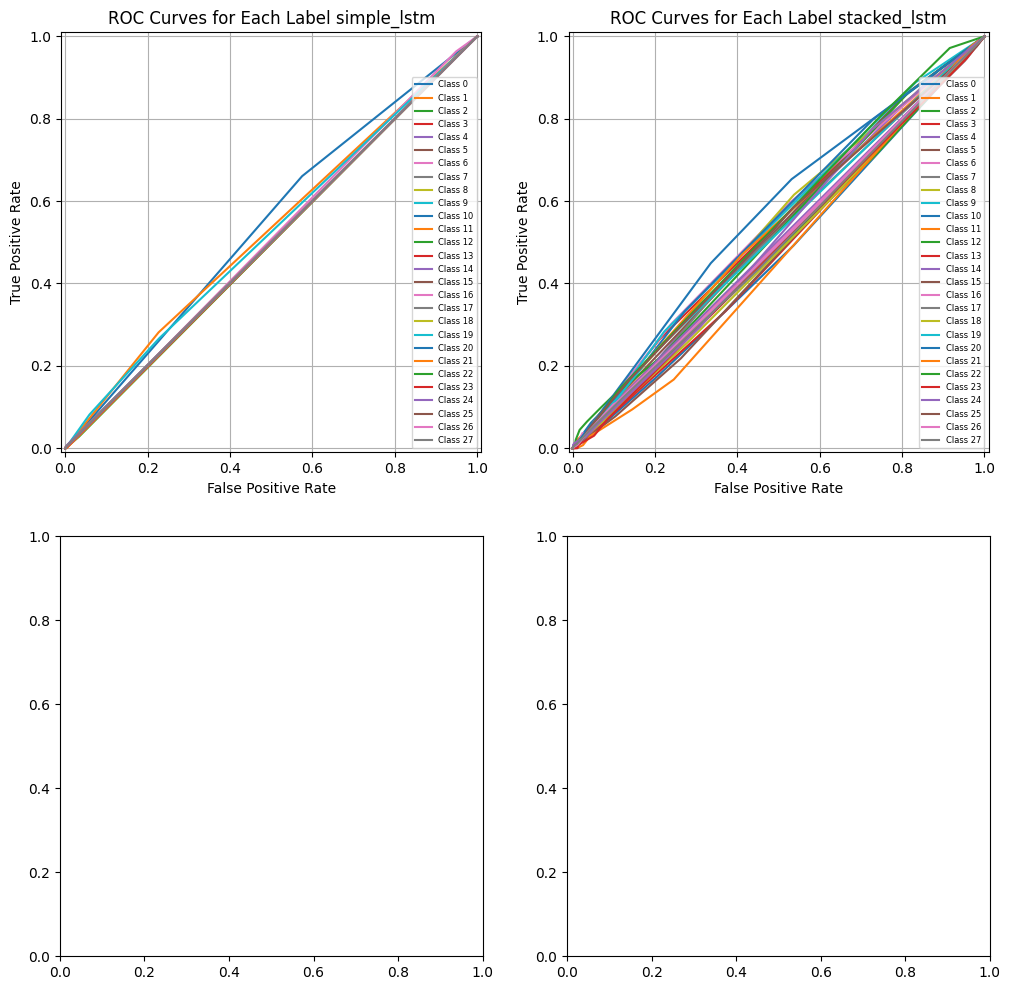

In [58]:
figure, ax = plt.subplots(2, 2, figsize=(12, 12))
axes = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]];

for i in range(0, len(models)):
    score = plot_roc_curve(X_test, y_test, models[i], axes[i])

    print(score)

Plot the mean ROC AUC scores. Which model has the highest score? On what kind of dataset?

In [59]:
def plot_mean_roc_auc(
    X: np.ndarray,
    y: np.ndarray,
    model: keras.Model,
    ax: plt.Axes | None = None
) -> float:
    """
    Plots the mean ROC AUC curve (averaging across labels) and outputs the mean ROC AUC score.

    Arguments:
        X: model inputs
        y: ground truths
        model: model to plot the curve for
        ax: axes to plot on (optional).

    Returns:
        Mean ROC AUC score.
    """
    y_pred_proba = model.predict(X)
    n_classes = y.shape[1]

    roc_auc_scores = []
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)

        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

    mean_tpr /= n_classes
    mean_tpr[-1] = 1.0 
    mean_roc_auc = auc(mean_fpr, mean_tpr)

    ax.plot(mean_fpr, mean_tpr, color='blue', label=f"Mean ROC AUC = {mean_roc_auc:.4f}", lw=2)
    ax.fill_between(mean_fpr, mean_tpr - 0.05, mean_tpr + 0.05, color='blue', alpha=0.1)

    ax.set_title(f"Mean ROC Curve Across All Labels {model.name}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)

    return mean_roc_auc

661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
0.5035058148055567
661/661 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step
0.512104213126214


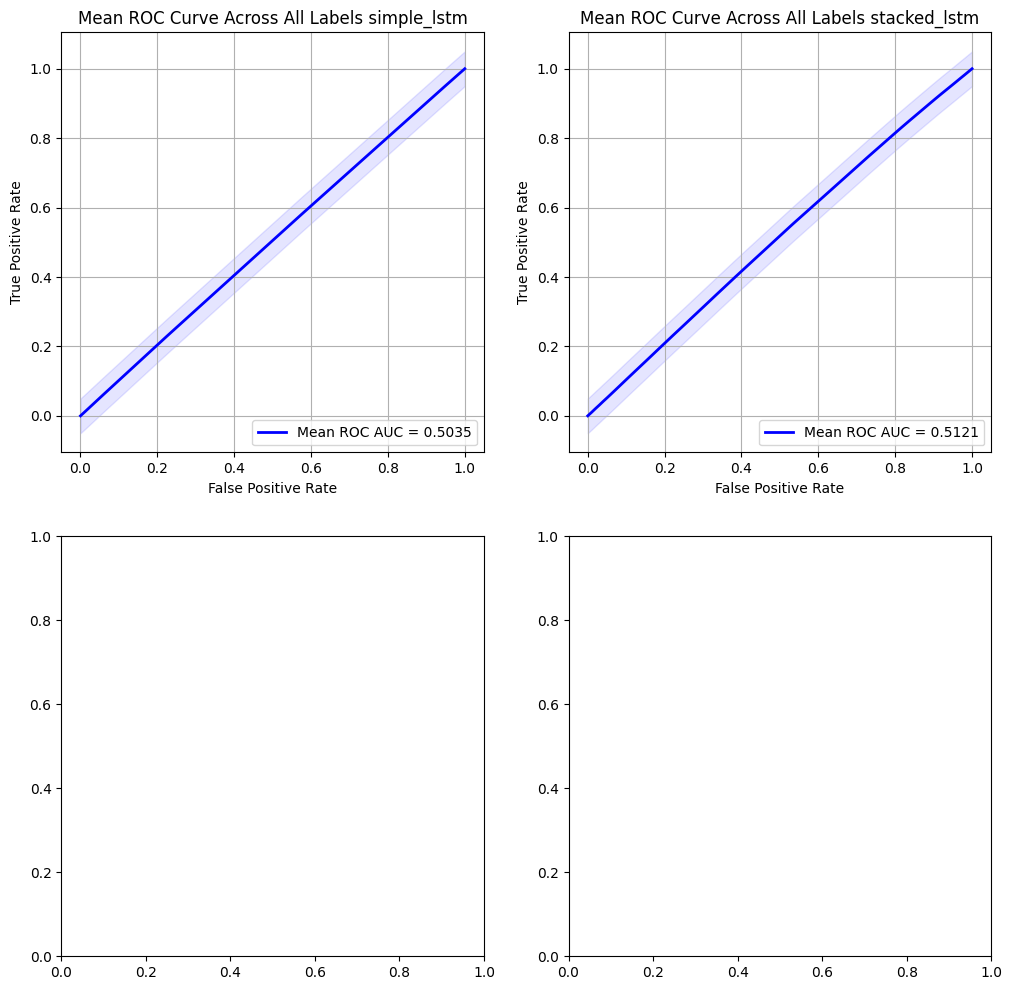

In [60]:
figure, ax = plt.subplots(2, 2, figsize=(12, 12))
axes = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]];

for i in range(0, len(models)):
    score = plot_mean_roc_auc(X_test, y_test, models[i], axes[i])

    print(score)

Inspect the best model performance closer. Come up with some sentences (in English). Does the model output sensible results?

In [ ]:
def label_text(text: str, model: keras.Model, threshold: float = 0.5, max_length: int | None = None) -> list[str]:
    '''Computes the model output for `text` and outputs a list of emotions that have a probability of at least `threshold`

    Arguments:
        text: text to label
        model: model to use
        threshold: threshold to use
        max_length: max length for tokenization
    
    Return:
        List of predicted emotion labels'''

In [ ]:
def plot_emotion_scores(text: str, model: keras.Model, max_length: int | None = None, ax: plt.Axes | None = None):
    '''Plots a bar plot of emotion probabilities for given `text` using `model`.

    Arguments:
        text: text to label
        model: model to use        
        max_length: max length for tokenization
        ax: axes to plot on'''

For each of your texts get a list of emotion labels and plot emotion scores

# Bonus

Train and evaluate the same model as your best one, but use a different cell type